# Multiple sequence alignment

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
data_dir = './data/msa'
import time
import os

In [7]:
import Bio
from Bio import SeqIO
msa = Bio.SeqIO.parse(os.path.join(data_dir, 'PF16592_ncbi.txt'), 'fasta')
msa = np.array([np.array(s.seq) for s in msa]).T

In [8]:
# number of AAs that occur at each residue
m = np.array([len(np.unique(s)) for s in msa])
# filter out residues that less than 3 AAs
msa = msa[m > 2]
m = m[m > 2]
# data dimensions
n, l = msa.shape
print 'sequence length (n): %i, number of sequences (l): %i' % (n, l)
# elements of data matrix
print 'AAs: %s' % (np.unique(msa),)

sequence length (n): 907, number of sequences (l): 1115
AAs: ['-' 'A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T'
 'V' 'W' 'X' 'Y']


In [9]:
import fem
iters = 20

m_sum = m.sum()
m_cumsum = np.insert(m.cumsum(), 0, 0)

data_files = [os.path.join(data_dir, f) for f in ['h1.npy', 'disc.npy']]

if np.all([os.path.exists(f) for f in data_files]):
    h1, disc = [np.load(f) for f in data_files]
else:
    start = time.time()
    par, disc = [], []
    for i in range(n):
        not_i = list(set(range(n)) - {i})
        x, y = msa[not_i], msa[i]
        res = fem.fit.fit(x, y, degs=[1], iters=iters)
        par.append(res[0])
        disc.append(np.squeeze(res[1]))
    end = time.time()
    print '%02f minutes' % ((end-start)/60.,) # 167.034068 minutes
    
    h1 = np.zeros(shape=(m_sum, m_sum))
    for i in range(n):
        m1, m2 = m_cumsum[i], m_cumsum[i+1]
        h1[m1:m2, :m1] = par[i][1][:,:m1]
        h1[m1:m2, m2:] = par[i][1][:,m1:]
    np.save(data_files[0], h1)

    disc = np.array(disc)
    np.save(data_files[1], disc)

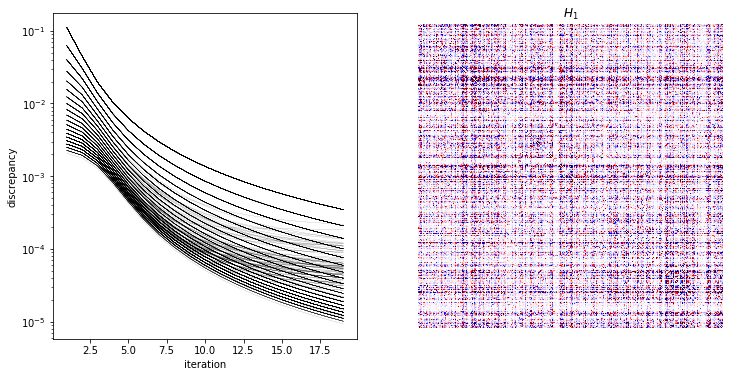

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for d in disc:
    ax[0].semilogy(range(1, 20), d, 'k-', lw=0.1)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('discrepancy')

for i in range(n):
    i1, i2 = m_cumsum[i], m_cumsum[i+1]
    h1[:, i1:i2] -= h1[:, i1:i2].mean(1)[:,np.newaxis]
scale = 0.01 * np.abs(h1).max()

ax[1].imshow(h1, aspect='equal', cmap=plt.cm.seismic, vmin=-scale, vmax=scale)
ax[1].axis('off')
ax[1].set_title('$H_1$')

plt.show()

In [ ]:
# pymol -qcr <script.py>
# ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam31.0/